In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis

In [10]:
# Read depression_cleaned.csv into DataFrame.
df = pd.read_csv("depression_cleaned.csv")

df.head(5)

,id,date,tweet,label,weekday,month,year,day,hour
0,637894677824413696,2015-08-30 07:48:37+00:00,diagnose anxiety depression moment reflect far...,1,Sunday,August,2015,30,7
1,637890384576778240,2015-08-30 07:31:33+00:00,sunday need break planning spend little possib...,1,Sunday,August,2015,30,7
2,637749345908051968,2015-08-29 22:11:07+00:00,awake tire need sleep brain idea,1,Saturday,August,2015,29,22
3,637696421077123073,2015-08-29 18:40:49+00:00,retro bear perfect gift great beginner stitch ...,1,Saturday,August,2015,29,18
4,637696327485366272,2015-08-29 18:40:26+00:00,hard whether pack list life easier reinforce n...,1,Saturday,August,2015,29,18


### Handle Missing Data

##### There was no missing data found in the data cleaning process. However, after saving the cleaned data to depression_cleaned.csv, missing values are present.

In [11]:
print(df.isnull().sum())

id           0
date         0
tweet      405
label        0
weekday      0
month        0
year         0
day          0
hour         0
dtype: int64


In [12]:
# Fill missing values with the most frequent value in the column.
df['tweet'] = df['tweet'].fillna(df['tweet'].mode()[0])

In [13]:
print(df.isnull().sum())

id         0
date       0
tweet      0
label      0
weekday    0
month      0
year       0
day        0
hour       0
dtype: int64


## Basic Dataset Statistics

In [14]:
print(f"Dataset shape: {df.shape}")

Dataset shape: (19881, 9)


In [15]:
print(df['label'].value_counts())

label
1    9942
0    9939
Name: count, dtype: int64


## Basic Tweet Statistics

In [16]:
# Get the average number of words in the tweets by splitting on whitespace.
df['word_count'] = df['tweet'].apply(lambda x: len(x.split()))

print(f"Average word count: {df['word_count'].mean()}")

Average word count: 4.9291786127458375


In [17]:
# Get the average number of characters in the tweets.
df['tweet_length'] = df['tweet'].apply(len)

print(f"Average tweet length: {df['tweet_length'].mean()}")

Average tweet length: 33.39213319249535


# Feature Extraction

## Convert Text Data into Numerical Features

### CountVectorizer

##### CountVectorizer is a feature extraction method that converts the tweets into a matrix of token counts. This numerical representation is necessary for LDA, which can't directly process raw text. LDA specifically works well with CountVectorizer because it's designed to model word counts rather than normalised values.

##### Words appearing in 95% or more of the tweets will be ignored, filtering out common words.
##### Words appearning in fewer than 2 tweets will be ignored, filtering out rare words.
##### The vocabulary size is limited to the top 5,000 most frequently occurring words.

In [18]:
# Use CountVectorizer for LDA.
count_vectoriser = CountVectorizer(max_df=0.95, min_df=2, max_features=5000)

##### The 'tweet' column is  transformed into a sparse matrix of word counts. The vocabulary is learnt from the text and the text is transformed into a word frequency matrix.

In [19]:
# Apply CountVectorizer to the 'tweet' column.
count_data = count_vectoriser.fit_transform(df['tweet'])

print(f"CountVectorizer shape: {count_data.shape}")

CountVectorizer shape: (19881, 5000)


##### There are 5,000 unique tokens in the vocabulary.

# Topic Modelling

### LDA (Latent Dirichlet Allocation)

##### LDA (Latent Dirichlet Allocation) the topic modelling technique used. It identifies patterns of co-occuring words in the tweets and groups them into coherent topics. 

In [20]:
# Create and fit the LDA model.
n_topics = 10

lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    learning_method='batch',
    max_iter=25,
    learning_offset=50.
)

lda.fit(count_data)

# Get topics for each tweet.
lda_output = lda.transform(count_data)

# Print the keywords for each topic.
feature_names = count_vectoriser.get_feature_names_out()

for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx + 1}:")
    # Print the top 10 keywords for each topic.
    print(" ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))

Topic 1:
good feel people need two life great care guy girl
Topic 2:
love happy play christmas birthday 2017 beautiful damn 5sos true
Topic 3:
fuck mental health hard hope anxiety woman think little tonight
Topic 4:
never ive miss ask sorry baby hell fuck man question
Topic 5:
trump best video live putin vote friend eat iheartawards wish
Topic 6:
show world cute cat top think listen business read die
Topic 7:
depression want treatment overcome help kid nanny therapy treat disorder
Topic 8:
shit game man think always lose ill team second okay
Topic 9:
someone hate god sleep bad lie need family everything money
Topic 10:
migraine positive work headache home pain word wrong addiction least


## Compare Topics Between Depressed and Non-Depressed Groups

<Figure size 1200x800 with 0 Axes>

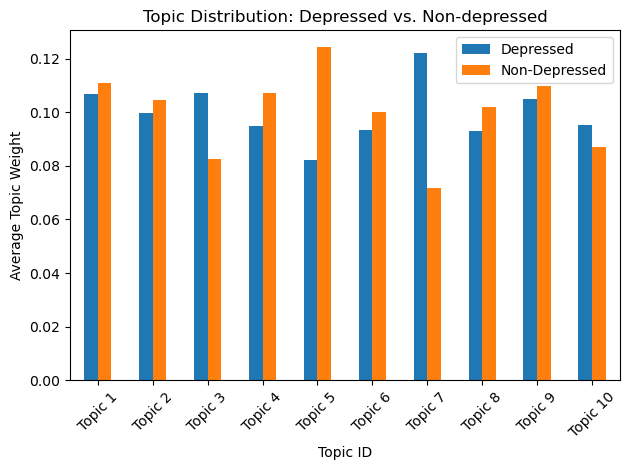

In [21]:
# Slice the LDA output based on the labels.
depressed_tweets = lda_output[df['label'] == 1]
non_depressed_tweets = lda_output[df['label'] == 0]

# Get average topic distribution for each group.
depressed_topic_dist = depressed_tweets.mean(axis=0)
non_depressed_topic_dist = non_depressed_tweets.mean(axis=0)

# Create a DataFrame for plotting.
topic_comparison = pd.DataFrame({
    'Depressed': depressed_topic_dist,
    'Non-Depressed': non_depressed_topic_dist
})

# Plot the comparison.
plt.figure(figsize=(12, 8))
topic_comparison.plot(kind='bar')
plt.title('Topic Distribution: Depressed vs. Non-depressed')
plt.xlabel('Topic ID')
plt.ylabel('Average Topic Weight')
plt.xticks(range(n_topics), [f'Topic {i+1}' for i in range(n_topics)], rotation=45)
plt.tight_layout()
plt.show()